In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:
import scutquant.scutquant as q
from scutquant import report, executor

model = q.auto_lgbm(X_train, y_train, X_valid, y_valid)

Training until validation scores don't improve for 30 rounds
[20]	train's l2: 0.883605	valid's l2: 0.898276
[40]	train's l2: 0.88118	valid's l2: 0.89703
[60]	train's l2: 0.879493	valid's l2: 0.896361
[80]	train's l2: 0.878114	valid's l2: 0.895932
[100]	train's l2: 0.876914	valid's l2: 0.895668
[120]	train's l2: 0.875764	valid's l2: 0.895423
[140]	train's l2: 0.874603	valid's l2: 0.895235
[160]	train's l2: 0.873577	valid's l2: 0.895053
[180]	train's l2: 0.872521	valid's l2: 0.894873
[200]	train's l2: 0.871502	valid's l2: 0.894779
[220]	train's l2: 0.870499	valid's l2: 0.894687
[240]	train's l2: 0.869357	valid's l2: 0.894621
[260]	train's l2: 0.868382	valid's l2: 0.894519
[280]	train's l2: 0.867378	valid's l2: 0.894473
[300]	train's l2: 0.866379	valid's l2: 0.894402
[320]	train's l2: 0.865355	valid's l2: 0.894343
[340]	train's l2: 0.864327	valid's l2: 0.894297
[360]	train's l2: 0.863314	valid's l2: 0.894257
[380]	train's l2: 0.862349	valid's l2: 0.894239
[400]	train's l2: 0.861421	valid'

In [3]:
import pandas as pd

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

,predict
count,281840.000000
mean,-0.000196
std,0.001943
min,-0.021823
25%,-0.001049
50%,-0.000008
75%,0.000890
max,0.019602


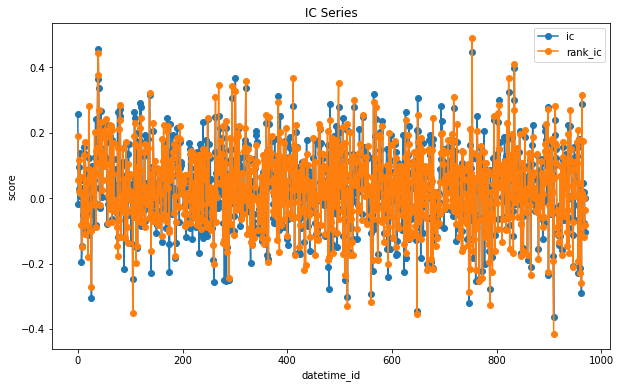

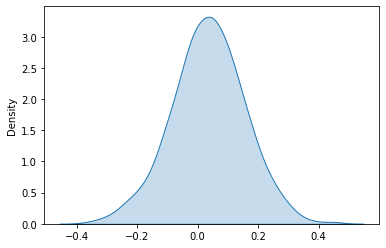

ic= 0.034317033407326974 icir= 0.28131526632120046 rank_ic= 0.03257033603942993 rank_icir= 0.2678922373216263


0.030770189491650467

In [4]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

Accuracy of Prediction: 0.5283347430220409


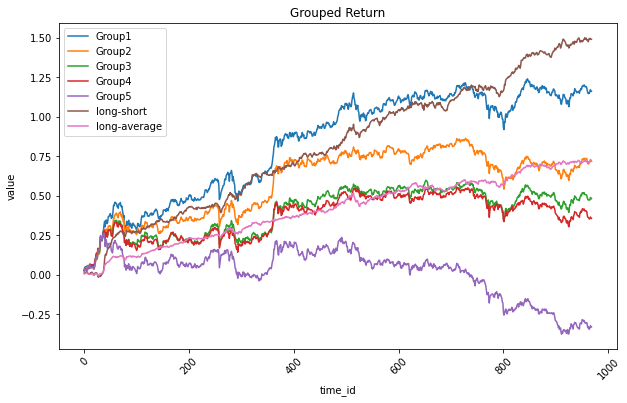

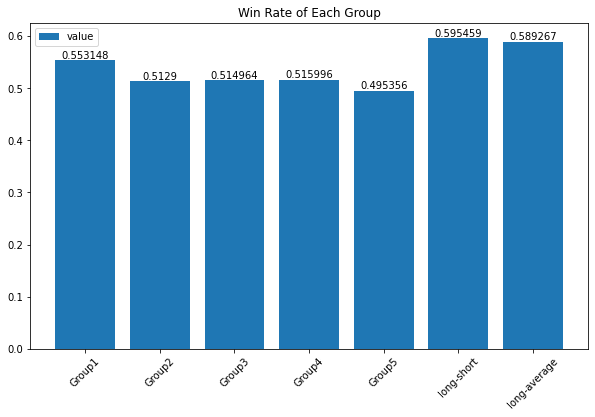

In [5]:
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
report.group_return_ana(pred, y_test)

In [6]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%的股票, 做空后20%的股票. 
        "kwargs": {
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 1000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 1  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

E(r): 0.5871745303655631
std: 0.25261018289848647
E(r_benchmark): 0.4145573363202267
std_benchmark: 0.1728743456410088 

Cumulative Rate of Return: 0.8425118789801795
Cumulative Rate of Return(benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.5029263159446309 

Max Drawdown: -0.29012907746918737
Max Drawdown(benchmark): -0.5462600364770351 

Sharpe Ratio: 2.3241040081930078
Sortino Ratio: 1.4196755920886275
Information Ratio: 0.6833342665157093 

Beta: 1.2137366837724635
Profitable Days(%): 0.9195046439628483


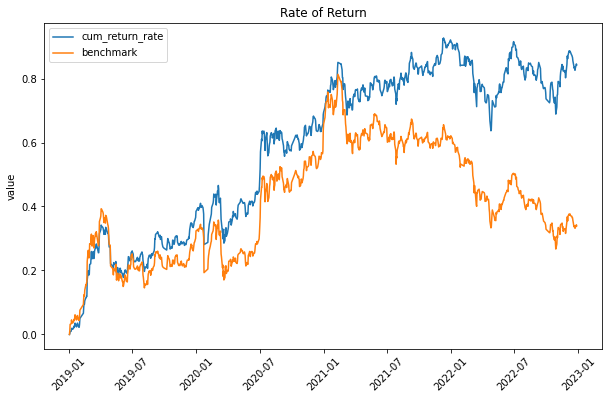

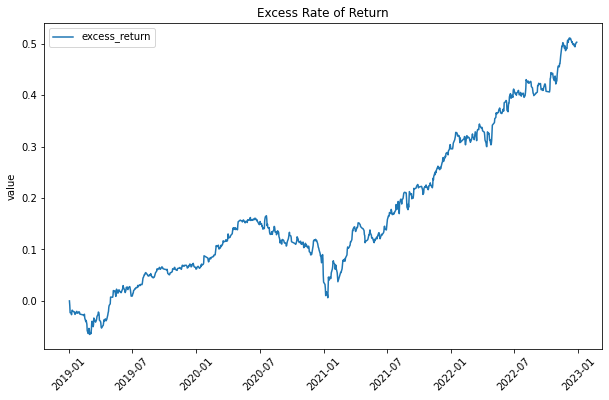

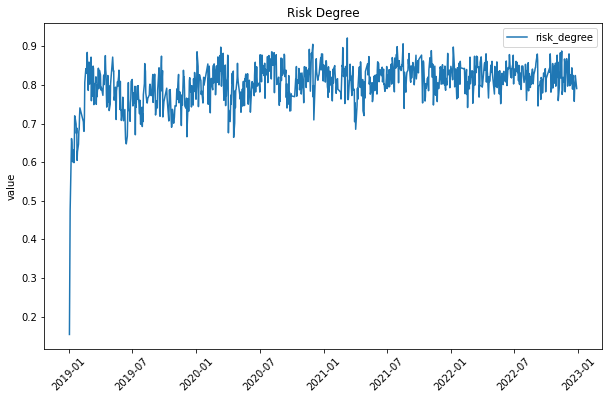

In [7]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [8]:
with open("lgbm/lgbm.pkl", "wb") as file:
    pickle.dump(model, file)
file.close()